In [1]:
import sys
sys.path.append("..")

In [2]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# No model integrates beyond this frame length; exclude from plots
max_frames = 26

In [4]:
# Get distribution of frame spans for words and phonemes according to state trajectory spec
with open("../out/state_space_specs/all_words.pkl", "rb") as f:
    word_trajectory_spec = pickle.load(f)
with open("../out/state_space_specs/all_phonemes_by_identity.pkl", "rb") as f:
    phoneme_trajectory_spec = pickle.load(f)

In [5]:
word_frame_durations = np.array([end - start for frame_spans in word_trajectory_spec.target_frame_spans for start, end in frame_spans])

<Axes: ylabel='Count'>

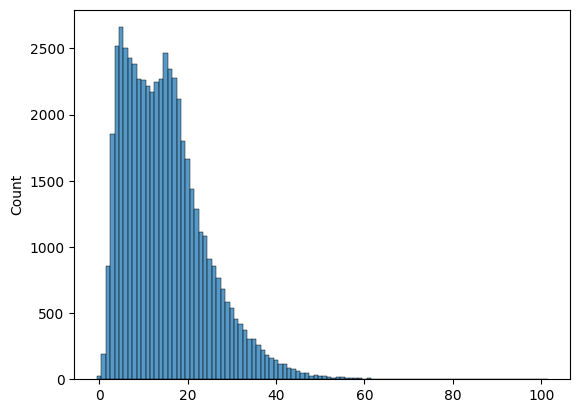

In [6]:
sns.histplot(word_frame_durations, discrete=True)

In [7]:
phoneme_frame_durations = np.array([end - start for frame_spans in phoneme_trajectory_spec.target_frame_spans for start, end in frame_spans])

<Axes: ylabel='Count'>

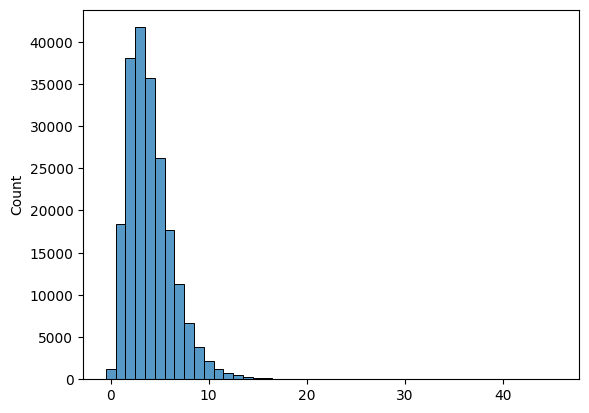

In [8]:
sns.histplot(phoneme_frame_durations, discrete=True)

## Lexical coherence

In [9]:
lexical_paths = list(Path("../outputs/notebooks").glob("**/lexical_coherence/distances.csv"))
lexical_keys, lexical_dfs = [], []
for path in lexical_paths:
    lexical_dfs.append(pd.read_csv(path))
    lexical_keys.append((path.parents[2].stem, path.parents[1].stem))

lexical_distance_df = pd.concat(lexical_dfs, names=["model", "equivalence"], keys=lexical_keys)
lexical_distance_df = lexical_distance_df[lexical_distance_df.frame <= max_frames]

# HACK
lexical_distance_df = lexical_distance_df[lexical_distance_df.word.str.len() >= 5]

lexical_distance_df

word  frame  distance  \
model   equivalence                                                        
w2v2_32 phoneme_within_word_prefix 6             greasy      0  0.370638   
                                   8              water      0  0.520660   
                                   11             don't      0  0.153334   
                                   15             carry      0  0.290738   
                                   27           forward      0  0.005710   
...                                                 ...    ...       ...   
w2v2_8  random                     240760       fortune     26  0.464557   
                                   240761        smiles     26  0.428687   
                                   240762      dislikes     26  0.508451   
                                   240763    appetizers     26  0.428931   
                                   240764  contributory     26  0.417410   

                                              type  
model   equivalence                                 
w2v2_32 phoneme_within_word_prefix 6        within  
                                   8        within  
                                   11       within  
                                   15       within  
                                   27       within  
...                                            ...  
w2v2_8  random                     240760  between  
                                   240761  between  
                                   240762  between  
                                   240763  between  
                                   240764  between  

[655452 rows x 4 columns]

In [10]:
list(lexical_distance_df.groupby(["model", "equivalence"]).groups.keys())

[('w2v2_32', 'phoneme_within_word_prefix'),
 ('w2v2_32', 'phoneme_within_word_suffix'),
 ('w2v2_32', 'random'),
 ('w2v2_32', 'word_suffix'),
 ('w2v2_8', 'next_phoneme'),
 ('w2v2_8', 'phoneme'),
 ('w2v2_8', 'random')]

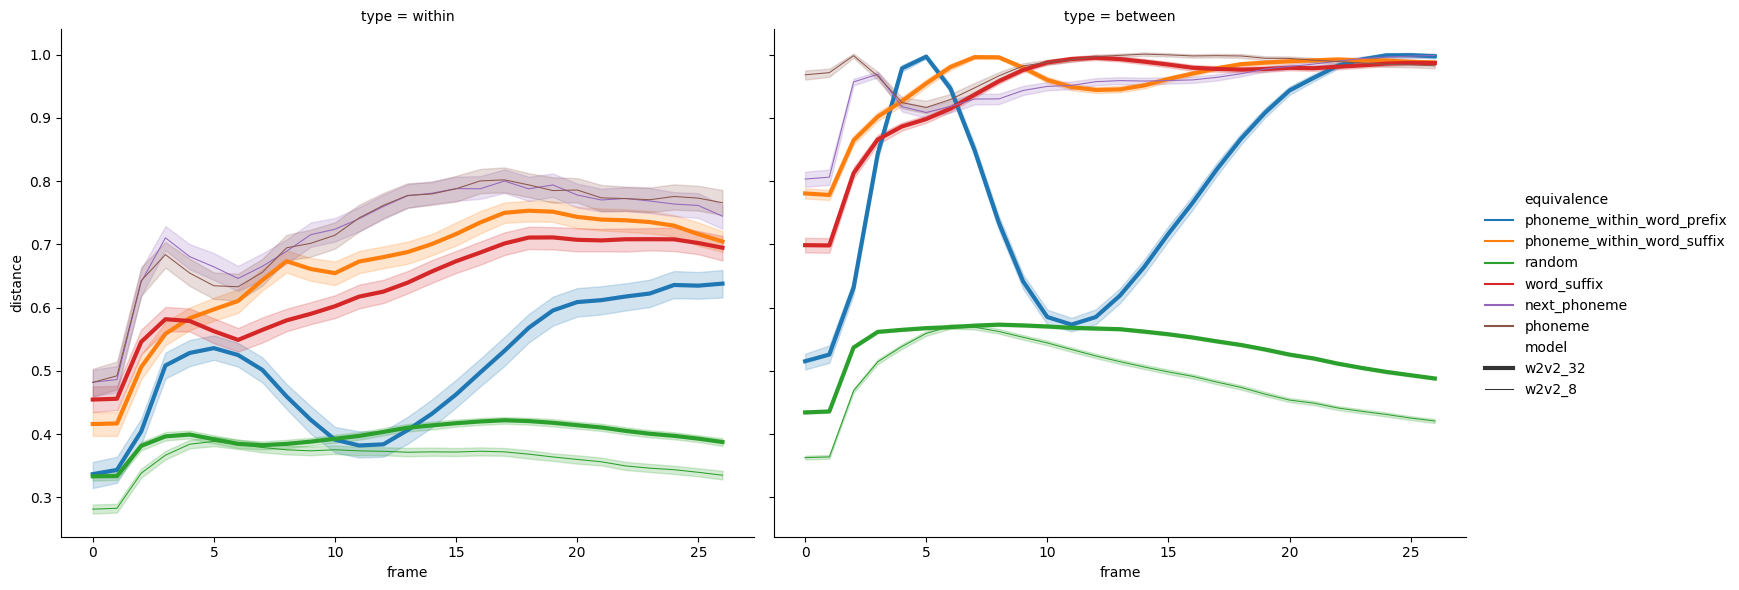

In [11]:
g = sns.FacetGrid(data=lexical_distance_df.reset_index(), col="type", height=6, aspect=1.25)
g.map(sns.lineplot, "frame", "distance", "equivalence", "model")
g.add_legend()

In [12]:
# Baseline distance estimates by random equivalent
baseline_lexical_df = {}
for (model, equivalence), values in lexical_distance_df.groupby(["model", "equivalence"]):
    if equivalence == "random":
        continue
    random_model = (model, "random")

    values = values.set_index(["type", "word", "frame"])
    random_values = lexical_distance_df.loc[random_model].set_index(["type", "word", "frame"])
    baseline_lexical_df[model, equivalence] = values.distance - random_values.distance

In [13]:
baseline_lexical_df = pd.DataFrame(pd.concat(baseline_lexical_df, names=["model", "equivalence"]))
baseline_lexical_df

distance
model   equivalence                type    word         frame          
w2v2_32 phoneme_within_word_prefix within  greasy       0      0.084557
                                           water        0      0.167515
                                           don't        0     -0.095260
                                           carry        0      0.023562
                                           forward      0     -0.323173
...                                                                 ...
w2v2_8  phoneme                    between fortune      26     0.746599
                                           smiles       26     0.554555
                                           dislikes     26     0.508559
                                           appetizers   26     0.629368
                                           contributory 26     0.580871

[468180 rows x 1 columns]

Text(0.5, 1.0, 'Baselined distance')

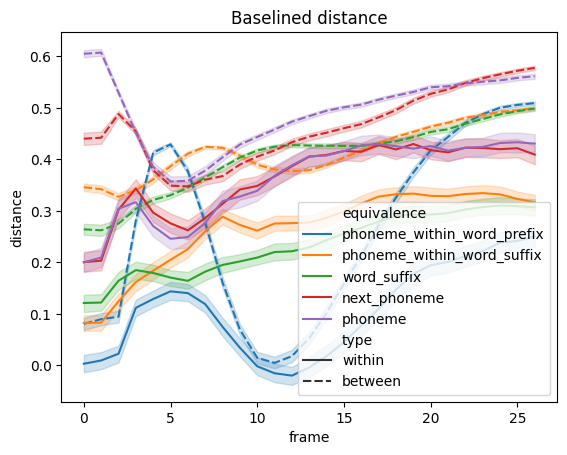

In [14]:
ax = sns.lineplot(data=baseline_lexical_df.reset_index(), x="frame", y="distance", hue="equivalence", style="type")
ax.set_title("Baselined distance")

Text(0.5, 1.0, 'Between-within contrast')

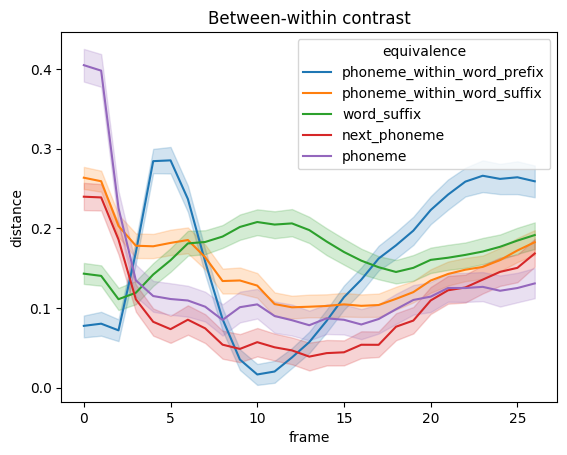

In [15]:
reindexed = baseline_lexical_df.reset_index().set_index(["type", "model", "equivalence", "word", "frame"])
lexical_within_vs_between = reindexed.loc["between"].distance - reindexed.loc["within"].distance
ax = sns.lineplot(data=lexical_within_vs_between.reset_index(),
                  x="frame", y="distance", hue="equivalence")
ax.set_title("Between-within contrast")

## Phoneme distance

In [16]:
phoneme_paths = list(Path("../outputs/notebooks").glob("**/phoneme_coherence/distances.csv"))
phoneme_keys, phoneme_dfs = [], []
for path in phoneme_paths:
    phoneme_dfs.append(pd.read_csv(path))
    phoneme_keys.append((path.parents[2].stem, path.parents[1].stem))

phoneme_distance_df = pd.concat(phoneme_dfs, names=["model", "equivalence"], keys=phoneme_keys)
phoneme_distance_df = phoneme_distance_df[phoneme_distance_df.frame <= max_frames]
phoneme_distance_df

word  frame  distance     type
model   equivalence                                                     
w2v2_32 phoneme_within_word_prefix 0        AA      0  1.003061   within
                                   1        AE      0  0.972680   within
                                   2        AH      0  0.989994   within
                                   3        AO      0  0.792097   within
                                   4        AW      0  0.793849   within
...                                        ...    ...       ...      ...
w2v2_8  random                     2915      W     26  0.509984  between
                                   2916      Y     26  0.497879  between
                                   2917      Z     26  0.506373  between
                                   2918     ZH     26  0.556258  between
                                   2919  [SIL]     26  0.546627  between

[15120 rows x 4 columns]

In [17]:
# Baseline distance estimates by random equivalent
baseline_phoneme_df = {}
for (model, equivalence), values in phoneme_distance_df.groupby(["model", "equivalence"]):
    if equivalence == "random":
        continue
    random_model = (model, "random")

    values = values.set_index(["type", "word", "frame"])
    random_values = phoneme_distance_df.loc[random_model].set_index(["type", "word", "frame"])
    baseline_phoneme_df[model, equivalence] = values.distance - random_values.distance

In [18]:
baseline_phoneme_df = pd.DataFrame(pd.concat(baseline_phoneme_df, names=["model", "equivalence"]))
baseline_phoneme_df

distance
model   equivalence                type    word  frame          
w2v2_32 phoneme_within_word_prefix within  AA    0      0.434806
                                           AE    0      0.447284
                                           AH    0      0.425783
                                           AO    0      0.308783
                                           AW    0      0.287432
...                                                          ...
w2v2_8  phoneme                    between W     26     0.405406
                                           Y     26     0.452391
                                           Z     26     0.451015
                                           ZH    26     0.396229
                                           [SIL] 26     0.472233

[10800 rows x 1 columns]

<Axes: xlabel='frame', ylabel='distance'>

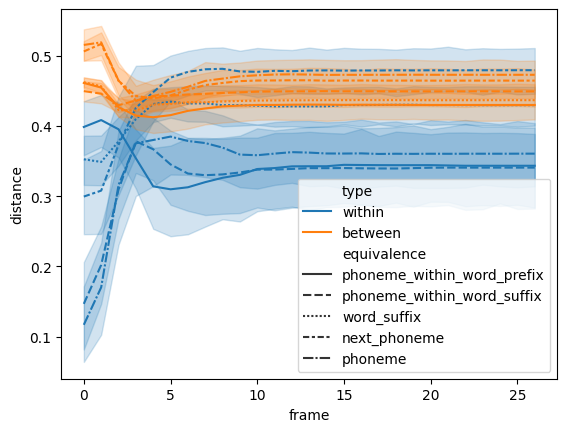

In [19]:
sns.lineplot(data=baseline_phoneme_df.reset_index(), x="frame", y="distance", hue="type", style="equivalence")

<Axes: xlabel='frame', ylabel='distance'>

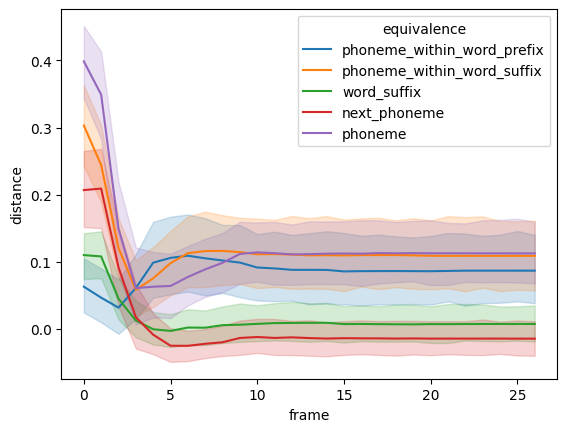

In [20]:
reindexed = baseline_phoneme_df.reset_index().set_index(["type", "model", "equivalence", "word", "frame"])
phoneme_within_vs_between = reindexed.loc["between"].distance - reindexed.loc["within"].distance
sns.lineplot(data=phoneme_within_vs_between.reset_index(),
             x="frame", y="distance", hue="equivalence")